In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# Importing the libraries 
import torch
import torchvision
import torchaudio
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib.cm as cm
import pandas as pd
import os
import librosa
import librosa.display
import torch.nn.functional as F
from torch.autograd import Variable
import time
# from Models import Autoencoder
from TestData import SingleMus
from Data_TIMIT import Data_TIMIT
import IPython.display as ipd
from IPython.display import clear_output
from Blocks import BasicBlock, Bottleneck
from EntropyControl import AE_control
from sep_models import Denoising

# Checking the availability of CUDA on machine
print("Torch", torch.__version__, "CUDA", torch.version.cuda)
print("Device:", torch.device("cuda:2"))
print(torch.cuda.is_available())



/media/sdb1/hy17/venv/lib/python3.6/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


Torch 1.4.0 CUDA 10.1
Device: cuda:2
True


## Data Preparation

- #### TIMIT Data

In [2]:
# overlap = 64
# data = Data_TIMIT('test', overlap = overlap)
# test_loader = torch.utils.data.DataLoader(data, batch_size = 1, shuffle \
#                                            = True, num_workers = 4)
# torch.save(test_loader, 'data/half_win_test_ctn_std_lm_same.pth')

In [3]:
# data = Data_TIMIT('train', mix_num = 1)
# train_loader = torch.utils.data.DataLoader(data, batch_size = 1, shuffle \
#                                            = True, num_workers = 4)
# torch.save(train_loader, 'data/half_win_train_ctn_std_lm.pth')

In [4]:
train_loader = torch.load('data/half_win_train_ctn_std4_m.pth')
test_loader = torch.load('data/half_win_test_ctn_std4_m.pth')

In [5]:
# print(len(train_loader),len(test_loader))

In [6]:
# for c, x, c_l, x_l in train_loader:
#     break
# print(c.shape)
# print(x.shape)
# print(c_l.shape)
# print(x_l.shape)

#### Dummy testing, for easy running

Test on whole wavefiles - able to be rebuild

In [7]:

def SISDR(s,sr,  cuda = False):
    
    eps = 1e-20
    scale = torch.sum(sr * s, dim = 1) / torch.sum(s**2, dim = 1) 
    scale = scale.unsqueeze(dim = 1) # shape - [50,1]
    s = s * scale
    sisdr = torch.mean(10*torch.log10(torch.sum(s**2, dim = 1)/(torch.sum((s-sr)**2, dim=1)+eps)+eps))
    if cuda:
        return torch.mean(sisdr)
    else:
        return torch.mean(sisdr).cpu().data.numpy()

def SDR(s, sr, cuda = False): # input (50, 512), (50, 512)
    
    eps=1e-20
    sdr = torch.mean(10*torch.log10(torch.sum(s**2, dim = 1)/(torch.sum((s-sr)**2, dim=1)+eps)+eps))
    
    if cuda:
        return sdr
    else:
        return sdr.cpu().data.numpy()

def melMSELoss(s, sr): # input waveform(torch.Tensor)
    
    n_mels = [8, 16, 32, 128]
    loss = 0
    eps = 1e-20
    mse = nn.MSELoss()
    for n in n_mels:
        s_mel = torchaudio.transforms.MelSpectrogram(n_fft=512, n_mels=n)(s)
        sr_mel = torchaudio.transforms.MelSpectrogram(n_fft=512, n_mels=n)(sr)
        s_mel = torch.log(s_mel + eps)
        sr_mel = torch.log(sr_mel + eps)
        m = mse(s_mel, sr_mel)
        loss += m
    return loss/len(n_mels)    
    

def rebuild(output, overlap = 64):
    output = output.cpu()
    len_wav = len(output) * (512 - overlap) + overlap
    wave = torch.zeros(len_wav)
    for i in range(len(output)):
        wave[i*(512-overlap):i*(512-overlap)+512] += output[i]       
    
    return wave

def test_newData():
#     model.eval()
    sdr_list_s = []
    sdr_list_x = []
    sdr_list_rs = []
    sdr_list_rx = []
    sdr_list_diff = []
    max_rs_sdr = 0
    max_rx_sdr = 0
    max_rs = None
    max_rx = None
    i = 0
    for wave_s, wave_x, source, mixture in test_loader: 
        
        source = source[0]
        mixture = mixture[0]
        noise = (mixture-source).cuda()
        source = source.cuda()
        mixture = mixture.cuda()
        s_h, n_h = model.forward_half(mixture)
        
#         n_h = mixture - s_h
        
        s_sdr = SISDR(source, s_h)
        x_sdr = SISDR(mixture, s_h + n_h)
        sdr_list_s.append(s_sdr)   
        sdr_list_x.append(x_sdr)
        
        rs = rebuild(s_h).unsqueeze(dim = 0)
        rn = rebuild(n_h).unsqueeze(dim = 0)
        
        rs_sdr = SISDR(wave_s, rs)
        rx_sdr = SISDR(wave_x, rs+rn)
        sdr_list_rs.append(rs_sdr)
        sdr_list_rx.append(rx_sdr)
        
        start_sdr = SISDR(wave_s, wave_x/max(wave_x[0]))
        sdr_list_diff.append(rs_sdr-start_sdr)
        
        if max_rs_sdr < rs_sdr:
            max_rs_sdr = rs_sdr
            max_rs = (rs, rn)
        if max_rx_sdr < rx_sdr:
            max_rx_sdr = rx_sdr
            max_rx = (rs, rn)
    
    s_score = np.mean(sdr_list_s) 
#     x_score = np.mean(sdr_list_x)
    rs_score = np.mean(sdr_list_rs)
    rx_score = np.mean(sdr_list_rx)
    diff_score = np.mean(sdr_list_diff)
    
    return s_score, rs_score, rx_score, diff_score, max_rs, max_rx


import collections

def cal_entropy(arg):
    
    entropy = 0
    counter = collections.Counter(arg)
    sum_v = sum(counter.values())
    for value in counter.values():
        p = value / sum_v
        entropy += -np.log(p)*p
        
    return entropy


## Model Define

In [10]:
ld = 0.1
model = Denoising(block = Bottleneck, d=100, f = 30).cuda()
lr = 0.0001    
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(list(model.parameters()) + [model.means_s] + [model.means_n], lr=lr) \
# #                              ,betas = (0.9, 0.99999))
optimizer = torch.optim.Adam(list(model.parameters()) , lr=lr) \
#                              ,betas = (0.9, 0.99999))
#                              weight_decay=1e-5)

## Train

block  lr= 0.0001, d = 50 <br>
new data

m - different channel

In [13]:
epochs = 50
epoch_list = []
max_sdr = 0
max_rs = None
t = 0
itermax = 0

while 1:
    start = time.time()
    model.train()
    train_sdr_rs = []
    train_sdr_rx = []
    train_mel_rs = []
    
    for wave_s, wave_x, source, mixture in train_loader:
        
        source = source[0]
        mixture = mixture[0]
#         wave_s *= 2
#         wave_x *= 2
        
        noise = (mixture - source).cuda()
        source = source.cuda()
        mixture = mixture.cuda()
        

        s_h, n_h = model.forward_half(mixture)
        
#         n_h = mixture - s_h
        
#         rs = rebuild(s_h).unsqueeze(dim = 0)
#         rn = rebuild(n_h).unsqueeze(dim = 0)


#         train_sdr_rs.append(SISDR(wave_s, rs))
#         train_sdr_rx.append(SISDR(wave_x, rs+rn))
#         train_mel = melMSELoss(wave_s, rs)
#       train_mel_rs.append(train_mel.cpu().data)

        optimizer.zero_grad()
#         loss = - SDR(wave_s, rs, cuda = True) - SDR(wave_x-wave_s, rn, cuda = True)\
#         - SDR(wave_x, rs+rn, cuda=True) 
        #+ 1/50 * train_mel
        loss = criterion(s_h, source) + criterion(n_h, noise) + criterion(s_h+n_h, mixture)
        loss.backward()
        optimizer.step()

    end = time.time()
    print('epoch_{}| Time:{:.0f} | Stage:{}'.format(t, end-start, model.stage))
    
    s_score, rs_score, rx_score, diff_score, max_rs, max_rx = test_newData()
        
    epoch_list.append((rs_score, rx_score))
    print('|Test- s: {:.2f}, rs: {:.2f}, rx: {:.2f}, diff: {:.2f} |'\
          .format(s_score, rs_score, rx_score, diff_score))
#     if t == 10:
#         model.stage = 1
    t += 1
    itermax += 1
    if rs_score > max_sdr:
        max_sdr = rs_score
        torch.save(model, '0513_denoising_on5db.model')  
        itermax = 0
    
    if model.stage == 0 and itermax == 5:
        model.stage = 1
    
    if model.stage == 1 and itermax == 10:
        break

          


epoch_0| Time:231 | Stage:0
|Test- s: 0.98, rs: 11.50, rx: 21.63, diff: 5.47 |
epoch_1| Time:225 | Stage:0
|Test- s: 0.80, rs: 11.78, rx: 21.61, diff: 5.75 |
epoch_2| Time:226 | Stage:0
|Test- s: 2.04, rs: 12.24, rx: 21.63, diff: 6.20 |
epoch_3| Time:227 | Stage:0
|Test- s: 1.72, rs: 12.56, rx: 21.65, diff: 6.52 |
epoch_4| Time:226 | Stage:0
|Test- s: 2.22, rs: 12.75, rx: 21.65, diff: 6.71 |
epoch_5| Time:230 | Stage:0
|Test- s: 2.92, rs: 12.98, rx: 21.72, diff: 6.95 |
epoch_6| Time:238 | Stage:0
|Test- s: 2.17, rs: 13.01, rx: 20.27, diff: 6.97 |
epoch_7| Time:237 | Stage:0
|Test- s: 3.16, rs: 13.28, rx: 21.62, diff: 7.25 |
epoch_8| Time:237 | Stage:0
|Test- s: 2.67, rs: 13.45, rx: 21.92, diff: 7.41 |
epoch_9| Time:237 | Stage:0
|Test- s: 3.54, rs: 13.55, rx: 22.02, diff: 7.51 |
epoch_10| Time:230 | Stage:0
|Test- s: 2.85, rs: 13.62, rx: 21.81, diff: 7.58 |
epoch_11| Time:227 | Stage:0
|Test- s: 2.98, rs: 13.76, rx: 21.98, diff: 7.73 |
epoch_12| Time:227 | Stage:0
|Test- s: 3.54, rs: 1

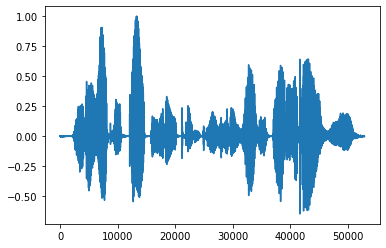

In [29]:
plt.plot(wave_s[0])

In [11]:
def get_n_params(model):
    count = 0
    for param in list(model.parameters()):
        nn = 1
        for s in list(param.size()):
            nn = nn*s
        count += nn
    return count
get_n_params(model)

5317132

In [12]:
max_sdr

11.793285

In [21]:
# torch.save(model, '0416_half_denoising_mel.model')

In [9]:
ipd.Audio(max_rs[0].cpu().data.numpy()[0], rate = 16000)

In [26]:
ipd.Audio('SAVED_RESULT/0410half21_65r.wav', rate = 16000)

In [26]:
ipd.Audio(max_rs[0].cpu().data.numpy()[0], rate = 16000)
# librosa.output.write_wav('0416half21_42r_mel.wav', max_rs[0].cpu().data.numpy()[0], sr = 16000)

In [10]:
ipd.Audio(max_rs[0].cpu().data.numpy()[0]+max_rs[1].cpu().data.numpy(), rate = 16000)
# librosa.output.write_wav('0410half21_65x.wav', max_rs[0].cpu().data.numpy()[0]+max_rs[1].cpu().data.numpy()[0], sr = 16000)

In [ ]:
criterion(outputs, data)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(arg.data.cpu().numpy().flatten())

## Listenning Test

In [61]:
def load_trim(wavpath, n, overlap=64):
    
    window = np.hamming(overlap*2) 
    window = np.concatenate((window[:overlap],np.ones(512-overlap*2),window[overlap:]))
    window = window.reshape(1,-1)
    window = window.astype(np.float32)
    
    try:
        c, cr = librosa.load(wavpath, sr = None)
        c /= max(c)
    except OSError:
        print('errorfile:',wavpath)
    
    n = n[len(n)//2:len(n)//2+len(c)]
    n = n/max(n)
    x = c + n
    
    c_l = []
    x_l = []
    
    for i in range(0, len(c), 512 - overlap):
        if i + 512 > len(c):
            break
        c_l.append(c[i:i+512])
        x_l.append(x[i:i+512])
    c_l = np.array(c_l)
    x_l = np.array(x_l)
    c = c[:len(c_l)*(512-overlap)+overlap]
    x = x[:len(c)]
    
    c_l = c_l * window
    x_l = x_l * window

    return c_l, c, x_l, x


def rebuild(output, overlap = 64):
    output = output.cpu()
    len_wav = len(output) * (512 - overlap) + overlap
    wave = torch.zeros(len_wav)
    for i in range(len(output)):
        wave[i*(512-overlap):i*(512-overlap)+512] += output[i]       
    
    return wave

def SDR(s, sr): # input (50, 512), (50, 512)
    
    eps=1e-20
    s = s.cpu().data.numpy()
    sr = sr.cpu().data.numpy()
    sdr = 10*np.log10(np.sum(s**2)/(np.sum((s-sr)**2)+eps)+eps)
    
    return sdr

In [62]:
# Compute entropy
import collections
def entropy(arg):
    entropy = 0
    counter = collections.Counter(arg)
    sum_v = sum(counter.values())
    for value in counter.values():
        p = value / sum_v
        entropy += - np.log(p)*p
    return entropy
    
# entropy(x)    

In [85]:
import IPython.display
import matplotlib.pyplot as plt
wavpath1 = '/media/sdc1/Data/timit-wav/train/dr1/fcjf0/sa1.wav'
wavpath2 = '/media/sdc1/Data/timit-wav/train/dr1/fcjf0/sa2.wav'
wavpath1 = '/media/sdc1/Data/timit-wav/test/dr1/msjs1/sx9.wav'

idx = 1
names = ['birds', 'computerkeyboard', 'jungle', 'ocean', 'casino', 'eatingchips', 'machineguns',\
                 'cicadas', 'frogs', 'motorcycles']
noise_path = '/media/sdc1/Data/Duan/{}.wav'.format(names[idx])
n, nr = librosa.load(noise_path, sr=None)

c_l, c, x_l, x = load_trim(wavpath1, n)


In [69]:
# # model = Autoencoder(block = Bottleneck,d = 15, num_m = 32, soft = True).cuda()
# model = torch.load('0304_entropy_control.model')

In [86]:
x_l.shape

(70, 512)

In [ ]:
model.eval()
x_l = torch.Tensor(x_l).cuda()
s_h, n_h= model.forward_half(x_l, soft = False)

NameError: name 'model' is not defined

In [93]:
rebuild(s_h).shape

torch.Size([31424])

In [95]:
torch.Tensor(c).shape

torch.Size([31424])

In [96]:
SISDR(rebuild(s_h)[None, :], torch.Tensor(c)[None,:])

array(8.338505, dtype=float32)

In [98]:
IPython.display.Audio(rebuild(s_h).cpu().data, rate = cr)

In [ ]:
data = torch.Tensor(trim(c1[:length])).cuda()
output1, arg1 = model.test_hard_qtz(data)
data = torch.Tensor(trim(c2[:length])).cuda()
output2, arg2 = model.test_hard_qtz(data)

In [ ]:
IPython.display.Audio(rebuild(output1)/max(c1)+rebuild(output2)/max(c2), rate = cr)

In [ ]:
muspath1 = '/media/sdc1/Data/ETRI_Music/1349-00002-RFO.wav'
m1, mr = librosa.load(muspath1)

In [ ]:
plt.plot(m1)

In [ ]:
dist1 = arg1.data.cpu().numpy().flatten()
dist2 = arg2.data.cpu().numpy().flatten()
dist_stk = np.hstack((dist1, dist2))

In [ ]:
dist_stk.shape

In [ ]:
print(entropy(dist1), entropy(dist2), entropy(dist), entropy(dist_stk))

In [ ]:
entropy(arg)

In [ ]:
x.reshape(-1, 3)